In [1]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gudhi as gd
import networkx as nx
from typing import List, Tuple

In [2]:
import surface_functions as sfun

In [3]:
# Define the 2D grid
x = np.linspace(-3, 3, 50)
y = np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x, y)

# Define the elevation function
# Z = sfun.himmelblau_function(X, Y)
Zs = []

Zs.append(sfun.surface1(X, Y))
Zs.append(sfun.surface2(X, Y))
Zs.append(sfun.himmelblau_function(X, Y))
Zs.append(sfun.ackley_function(X, Y))
Zs.append(sfun.rosenbrock_function(X, Y))
Zs.append(sfun.rastrigin_function(X, Y))
Zs.append(sfun.michalewicz_function(X, Y))
Zs.append(sfun.goldstein_price_function(X,Y))

In [4]:
# Contour tree construction
# This Should be imported from i python library that we made
def build_contour_tree(Z):
    G = nx.Graph()
    points = [(i, j) for i in range(Z.shape[0]) for j in range(Z.shape[1])]
    sorted_points = sorted(points, key=lambda p: Z[p])
    
    parent = {}
    contours = set()
    
    for p in sorted_points:
        x, y = p
        current_parent = p
        
        # Check neighbors and determine the parent
        if x > 0 and (x-1, y) in parent:
            current_parent = parent[(x-1, y)]
        if y > 0 and (x, y-1) in parent:
            if (x-1, y) in parent and parent[(x-1, y)] != parent[(x, y-1)]:
                G.add_edge(parent[(x-1, y)], parent[(x, y-1)])
                if parent[(x-1, y)] in contours:
                    contours.remove(parent[(x-1, y)])
                parent[(x-1, y)] = parent[(x, y-1)]
            current_parent = parent[(x, y-1)]
        
        # Assign the parent to the current point
        parent[p] = current_parent
        contours.add(current_parent)
    
    return G, list(contours)

In [5]:
contour_trees = []
contours_list = []

for Z in Zs:
    contour_tree, contours = build_contour_tree(Z)
    contour_trees.append(contour_tree)
    contours_list.append(contours)

In [6]:
len(contours_list[0])

615

In [7]:
def enumerate_point(i:int, j:int, dim:int) -> int:
    return (i * dim) + j if i==0 else (i * dim) + j + 1

In [8]:
def create_simplex_tree(X, Z):
    simplex_tree = gd.SimplexTree()
    dim = X.shape[0]
    
    # TODO: see if it is neccessary to insert every single edge that can be created, or is it 
    # sufficient to just insert edges of the points next to each other (like on the elevation map).
    
    # Insert vertices and edges of the 2D grid with filtration values as the height
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            simplex_tree.insert([enumerate_point(i,j,dim)], filtration=Z[i, j])
            if i > 0:
                simplex_tree.insert([
                    enumerate_point(i-1, j, dim),
                    enumerate_point(i, j, dim)
                ], filtration=max(Z[i-1, j], Z[i, j]))
            if j > 0:
                simplex_tree.insert([
                    enumerate_point(i, j-1, dim),
                    enumerate_point(i, j, dim)
                ], filtration=max(Z[i, j-1], Z[i, j]))

    # Insert 2-simplices (triangles)
    for i in range(X.shape[0] - 1):
        for j in range(X.shape[1] - 1):
            simplex_tree.insert([
                enumerate_point(i, j, dim),
                enumerate_point(i+1, j, dim),
                enumerate_point(i, j+1, dim)
            ], filtration=max(Z[i, j], Z[i+1, j], Z[i, j+1]))
            simplex_tree.insert([
                enumerate_point(i+1, j, dim),
                enumerate_point(i, j+1, dim),
                enumerate_point(i+1, j+1, dim)
            ], filtration=max(Z[i+1, j], Z[i, j+1], Z[i+1, j+1]))
    
    return simplex_tree

In [9]:
simplex_trees = []

for Z in Zs:
    simplex_tree = create_simplex_tree(X=X, Z=Z)
    simplex_trees.append(simplex_tree)

In [10]:
simplex_trees[0].num_vertices()

2500

In [11]:
for simplex_tree in simplex_trees:
    print(f"Dimension of the simplex tree:{simplex_tree.dimension()}")
    print(f"Number of vertices: {simplex_tree.num_vertices()}")
    print(f"Number of simplices: {simplex_tree.num_simplices()}")
    print("=======================================")

Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603
Dimension of the simplex tree:2
Number of vertices: 2500
Number of simplices: 14603


In [12]:
persistences = []

for simplex_tree in simplex_trees:
    simplex_tree.initialize_filtration()
    persistence = simplex_tree.persistence()
    persistences.append(persistence)

/tmp/ipykernel_11299/2355182856.py:4: DeprecationWarning: Since Gudhi 3.2, calling SimplexTree.initialize_filtration is unnecessary.
  simplex_tree.initialize_filtration()


/home/mihailo/Documents/Surface_Segmentation_3D_CT/.venv/lib/python3.10/site-packages/gudhi/persistence_graphical_tools.py:105: UserWarning: This function is not available.
ModuleNotFoundError: No module named 'matplotlib'.
  warnings.warn(f"This function is not available.\nModuleNotFoundError: No module named '{import_error.name}'.")


<Figure size 640x480 with 0 Axes>

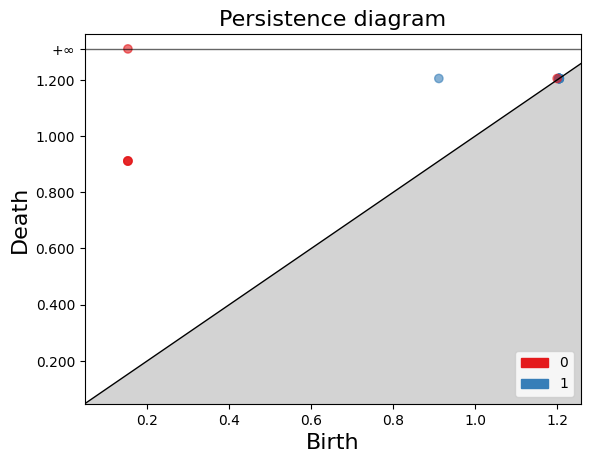

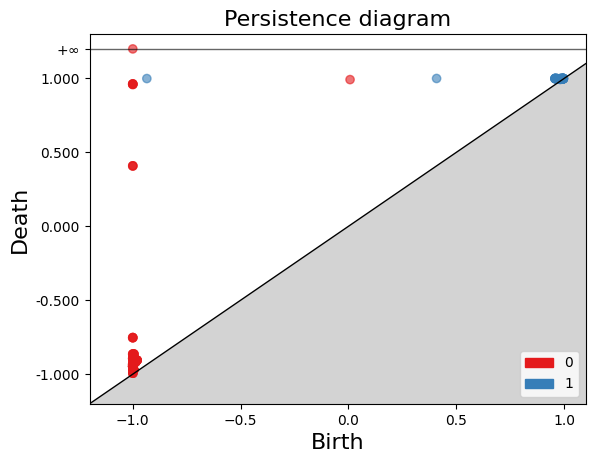

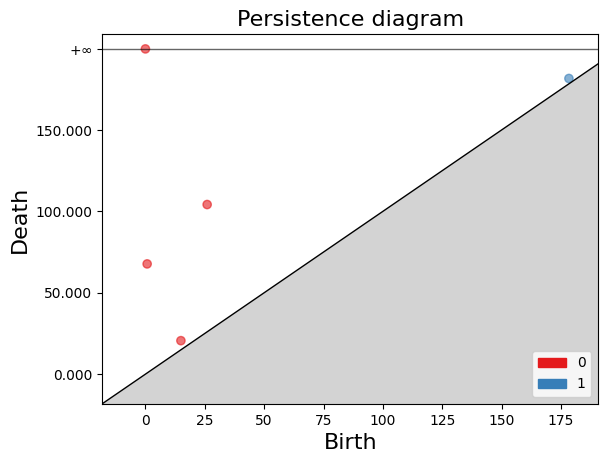

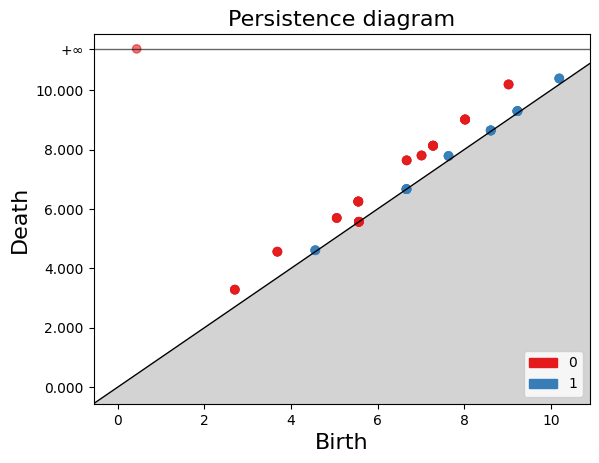

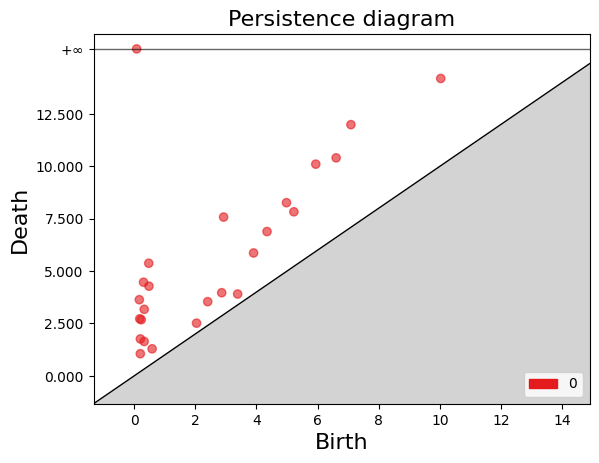

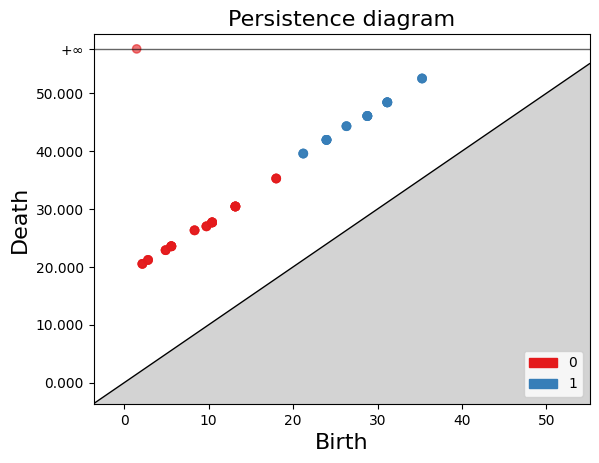

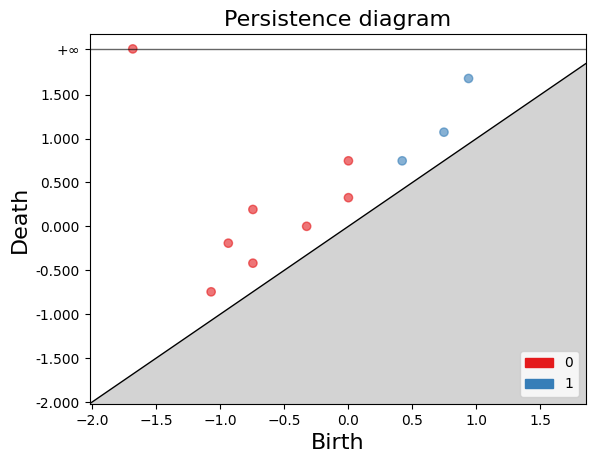

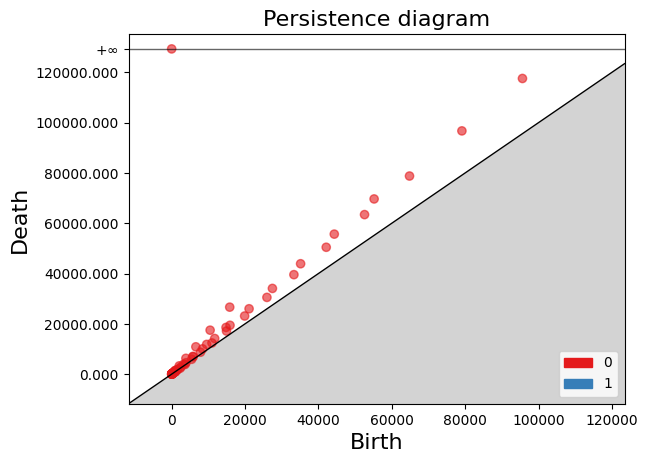

In [13]:
fig = plt.figure()
for persistence in persistences:
    _ = gd.plot_persistence_diagram(persistence)
plt.show()

In [14]:
def plot_3d_surface(
        X:List[int],
        Y:List[int],
        Zs:List[List[int]],
        contours_list:List[List[Tuple[int,int]]]
        ):
    fig = plt.figure(figsize=(24, 30))
    for i, (Z, contours) in enumerate(zip(Zs,contours_list)) :
        ax = fig.add_subplot(int(len(Zs) / 2),3, i+1, projection='3d')
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)
        
        for contour in contours:
            x, y = contour
            ax.scatter(X[x, y], Y[x, y], Z[x, y], color='r')
    
    plt.show()

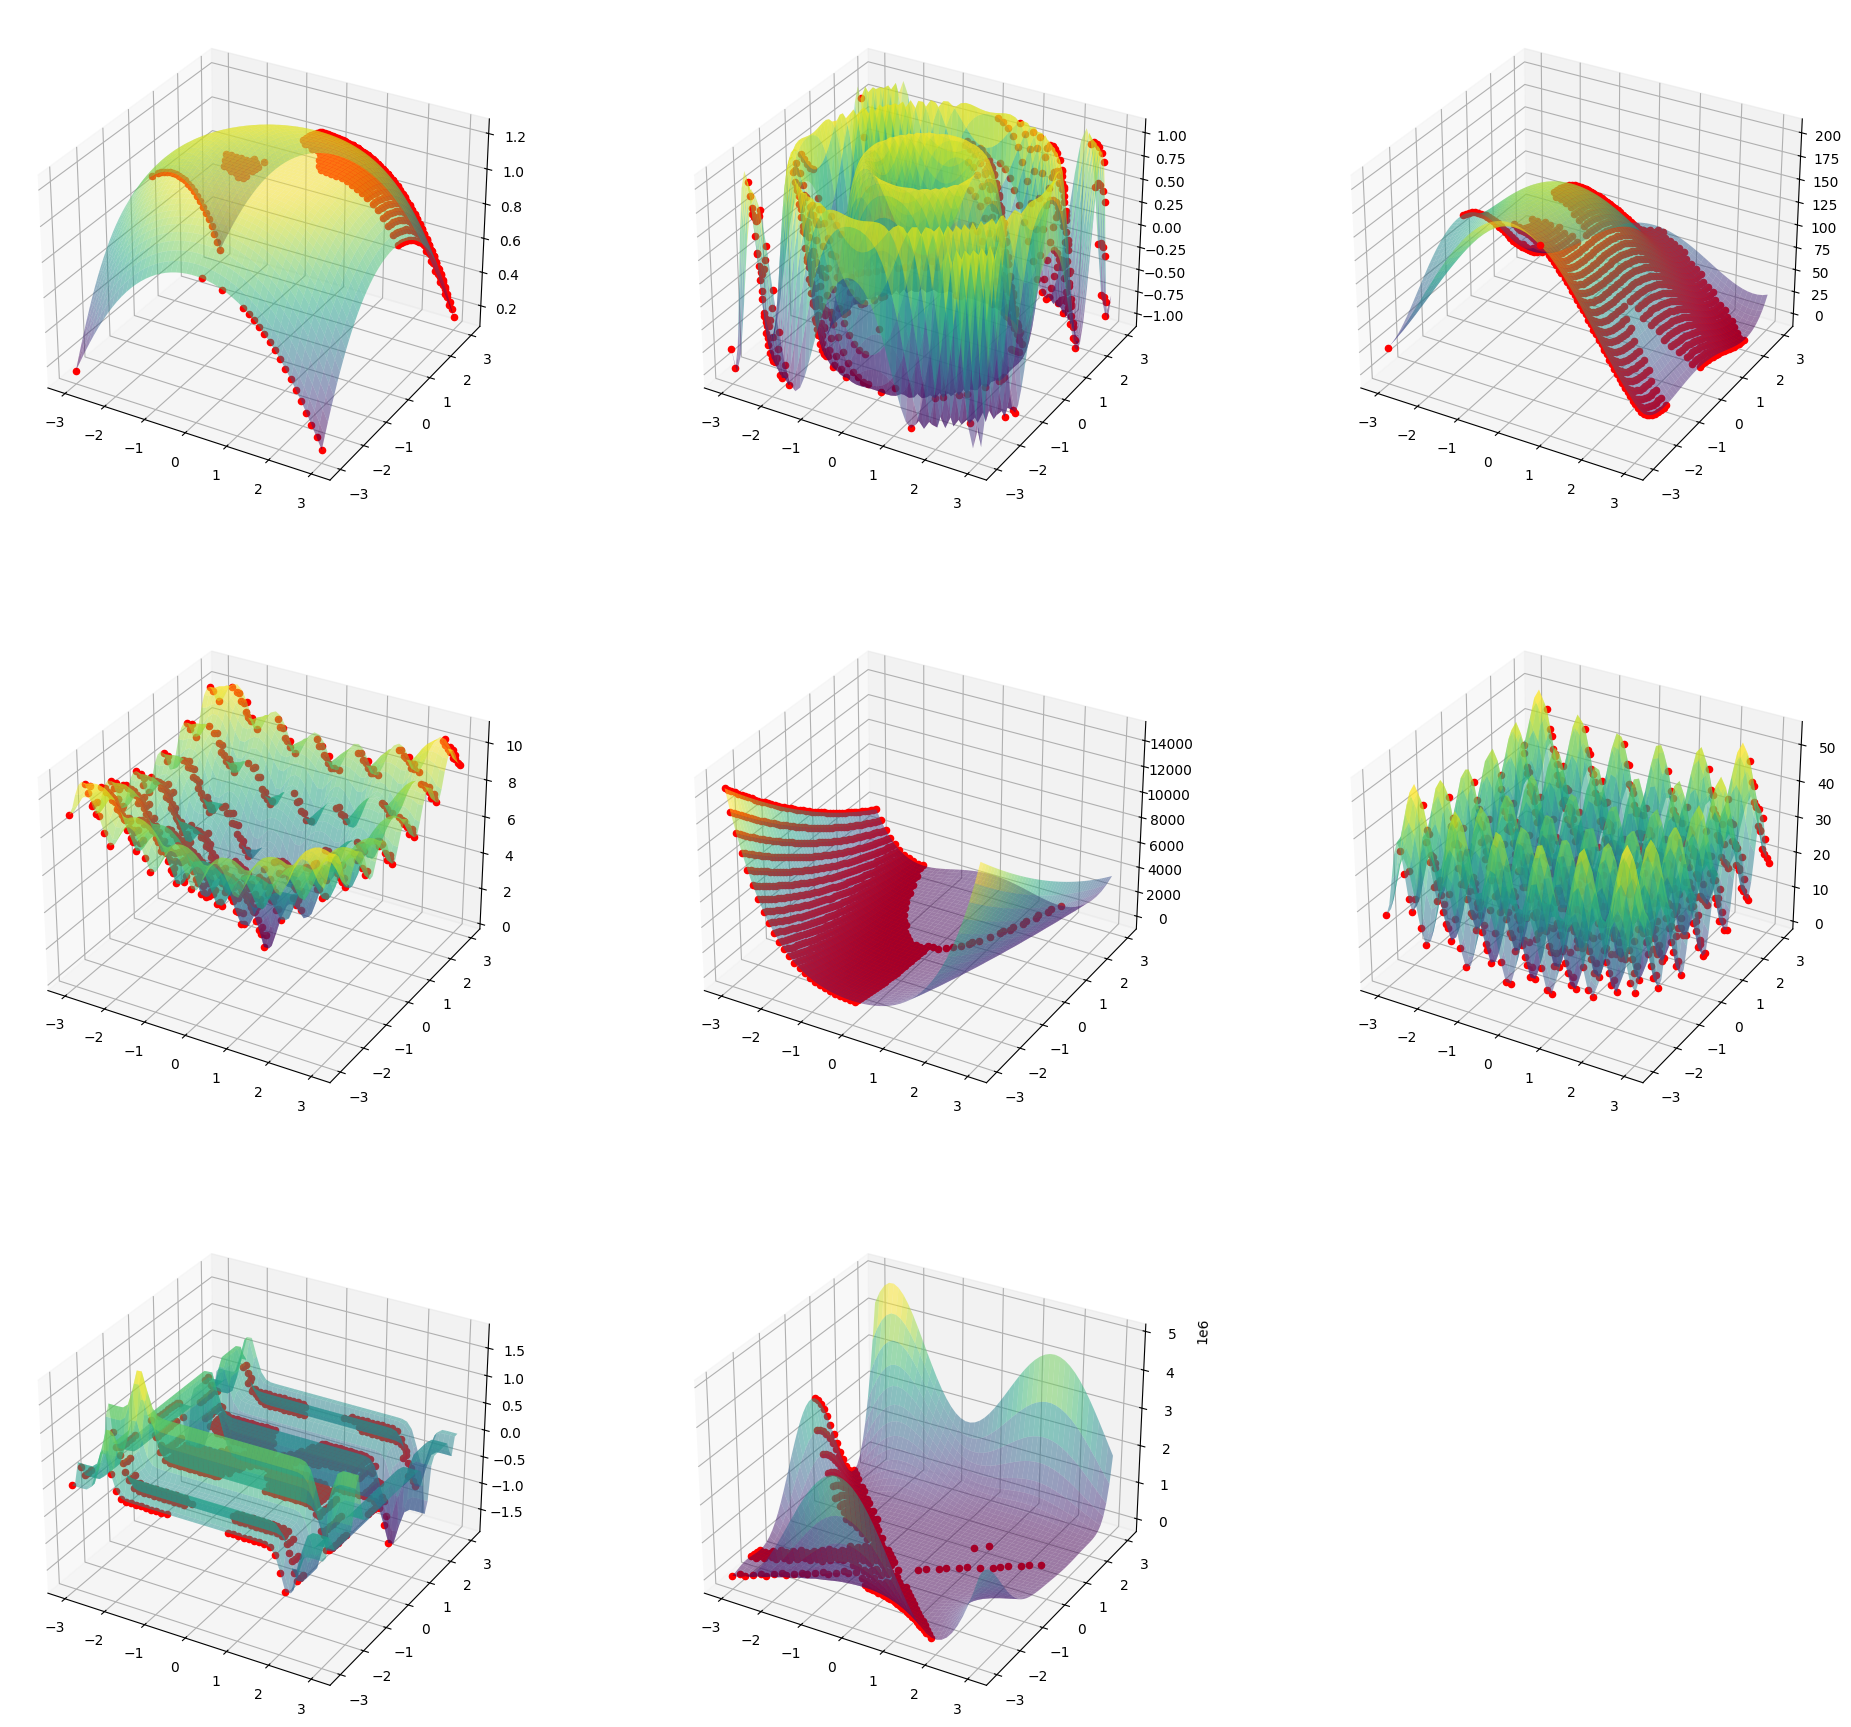

In [15]:
plot_3d_surface(X, Y, Zs, contours_list)

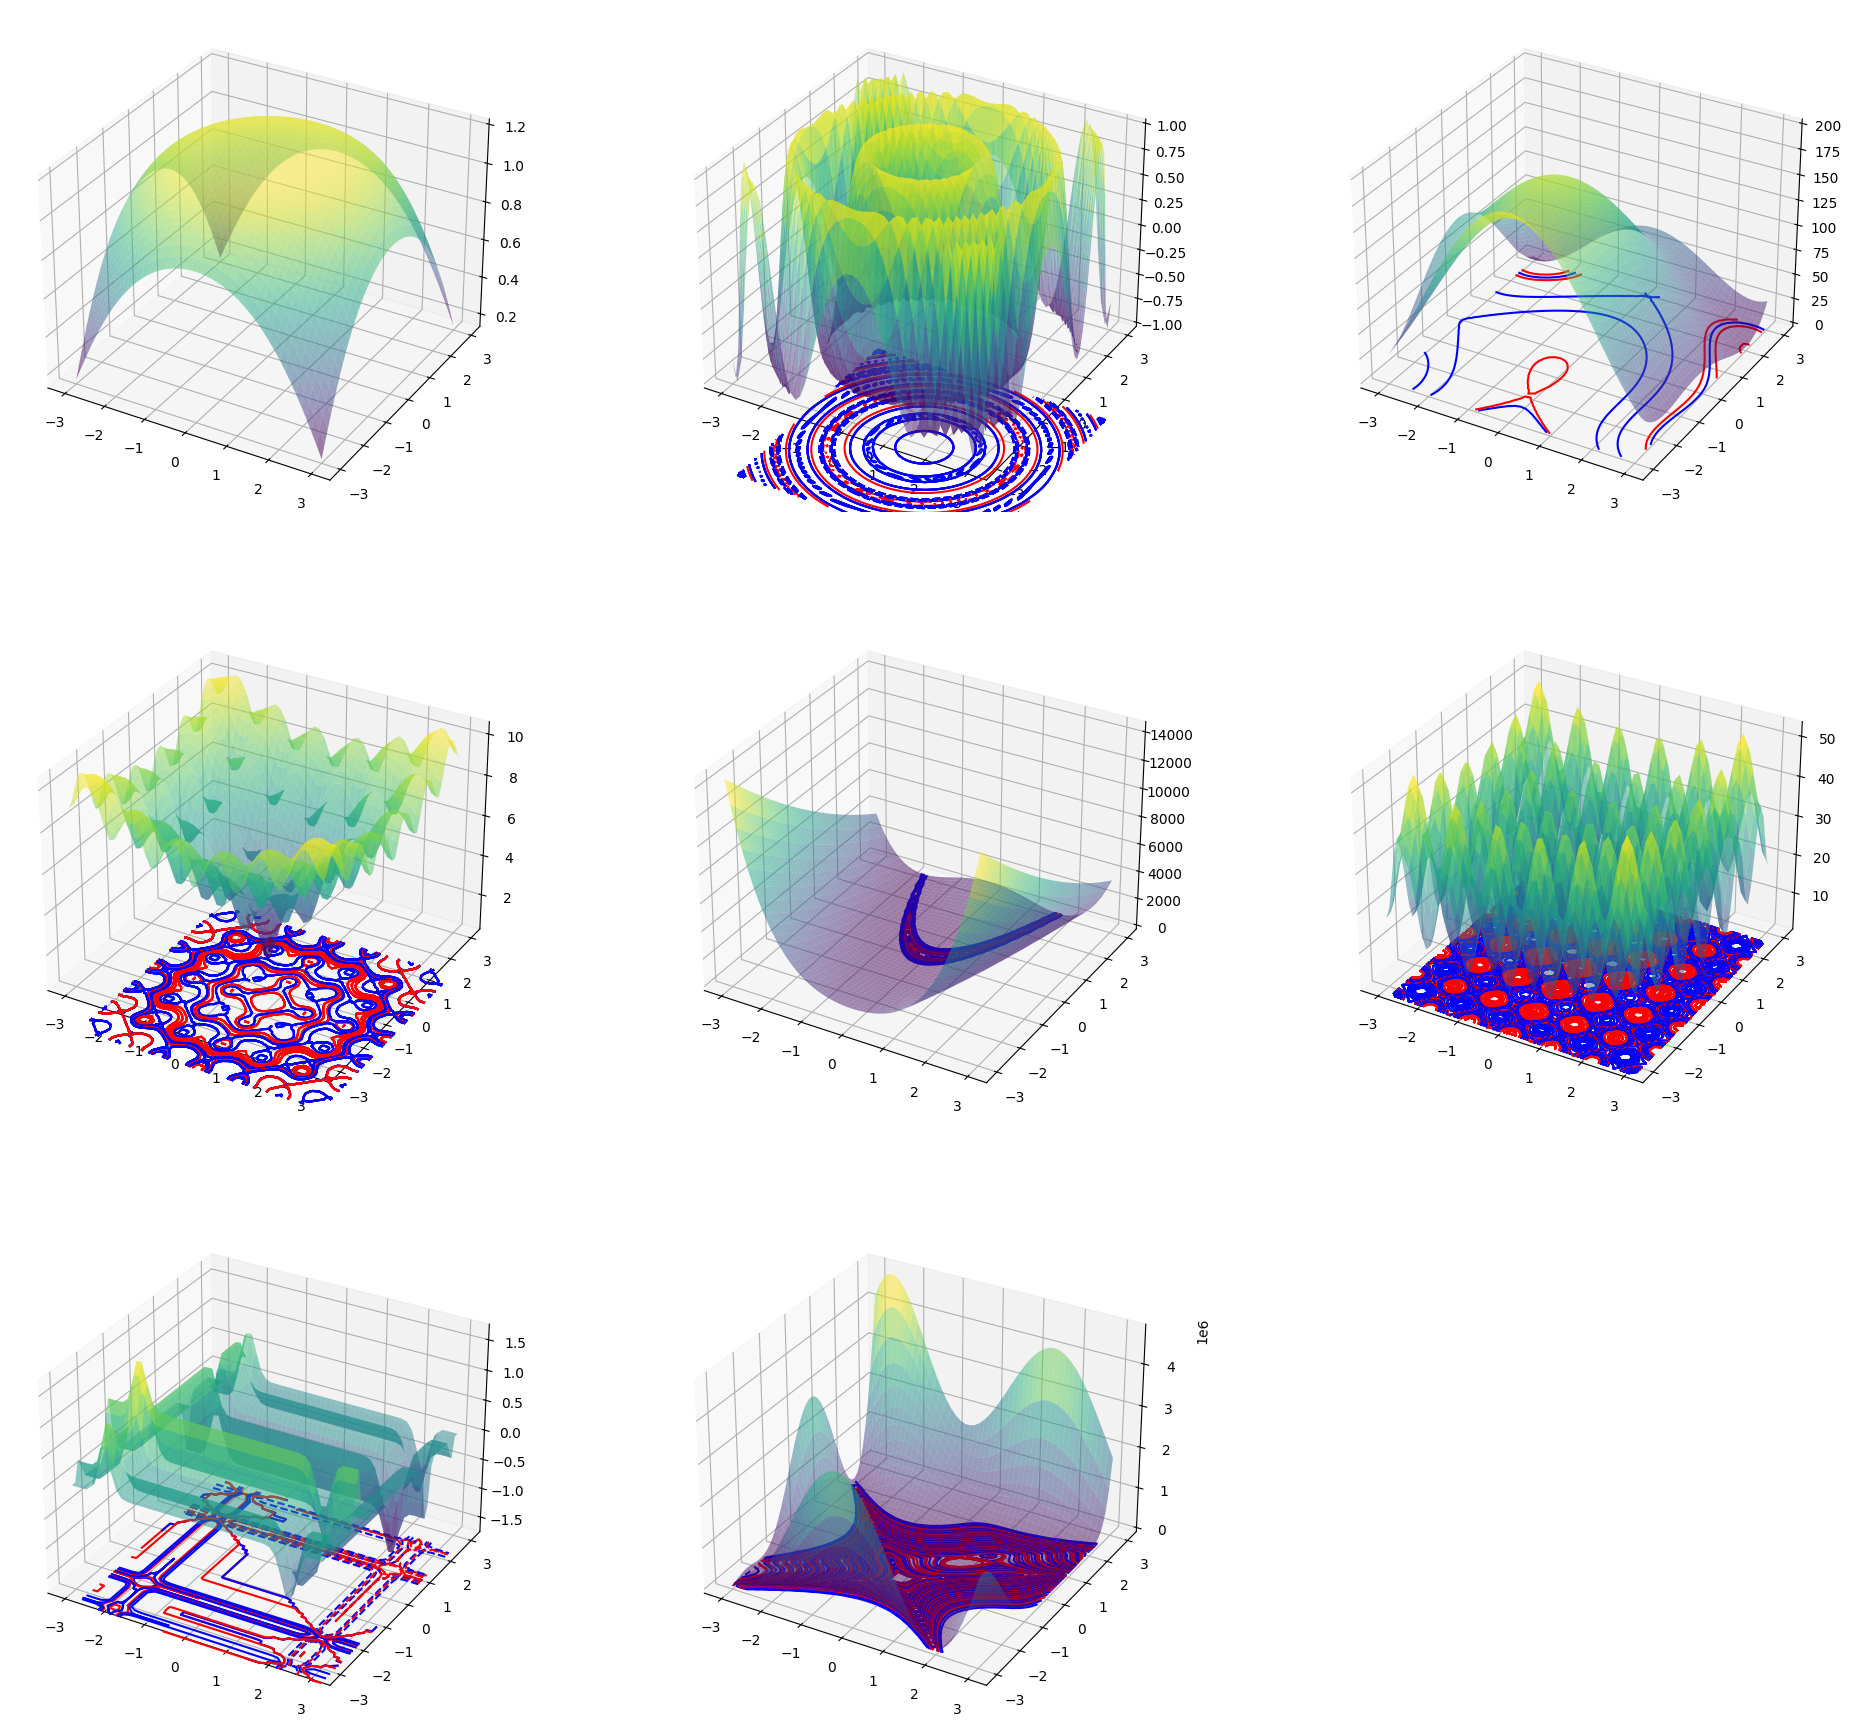

In [19]:
# Extract significant features (based on persistence)
fig = plt.figure(figsize=(24,30))
for i,(Z, persistence) in enumerate(zip(Zs, persistences)):
    significant_features = [p for p in persistence if p[1][1] - p[1][0] > 0.1]

    # Visualize the significant contours on the surface
    ax = fig.add_subplot(int(len(persistences)/2),3,i+1,  projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5)

    # Plot contours at significant birth and death levels
    for dimension, (birth, death) in significant_features:
        ax.contour(X, Y, Z, levels=[birth], zdir='z', offset=-2, colors='r')
        ax.contour(X, Y, Z, levels=[death], zdir='z', offset=-2, colors='b')

plt.show()

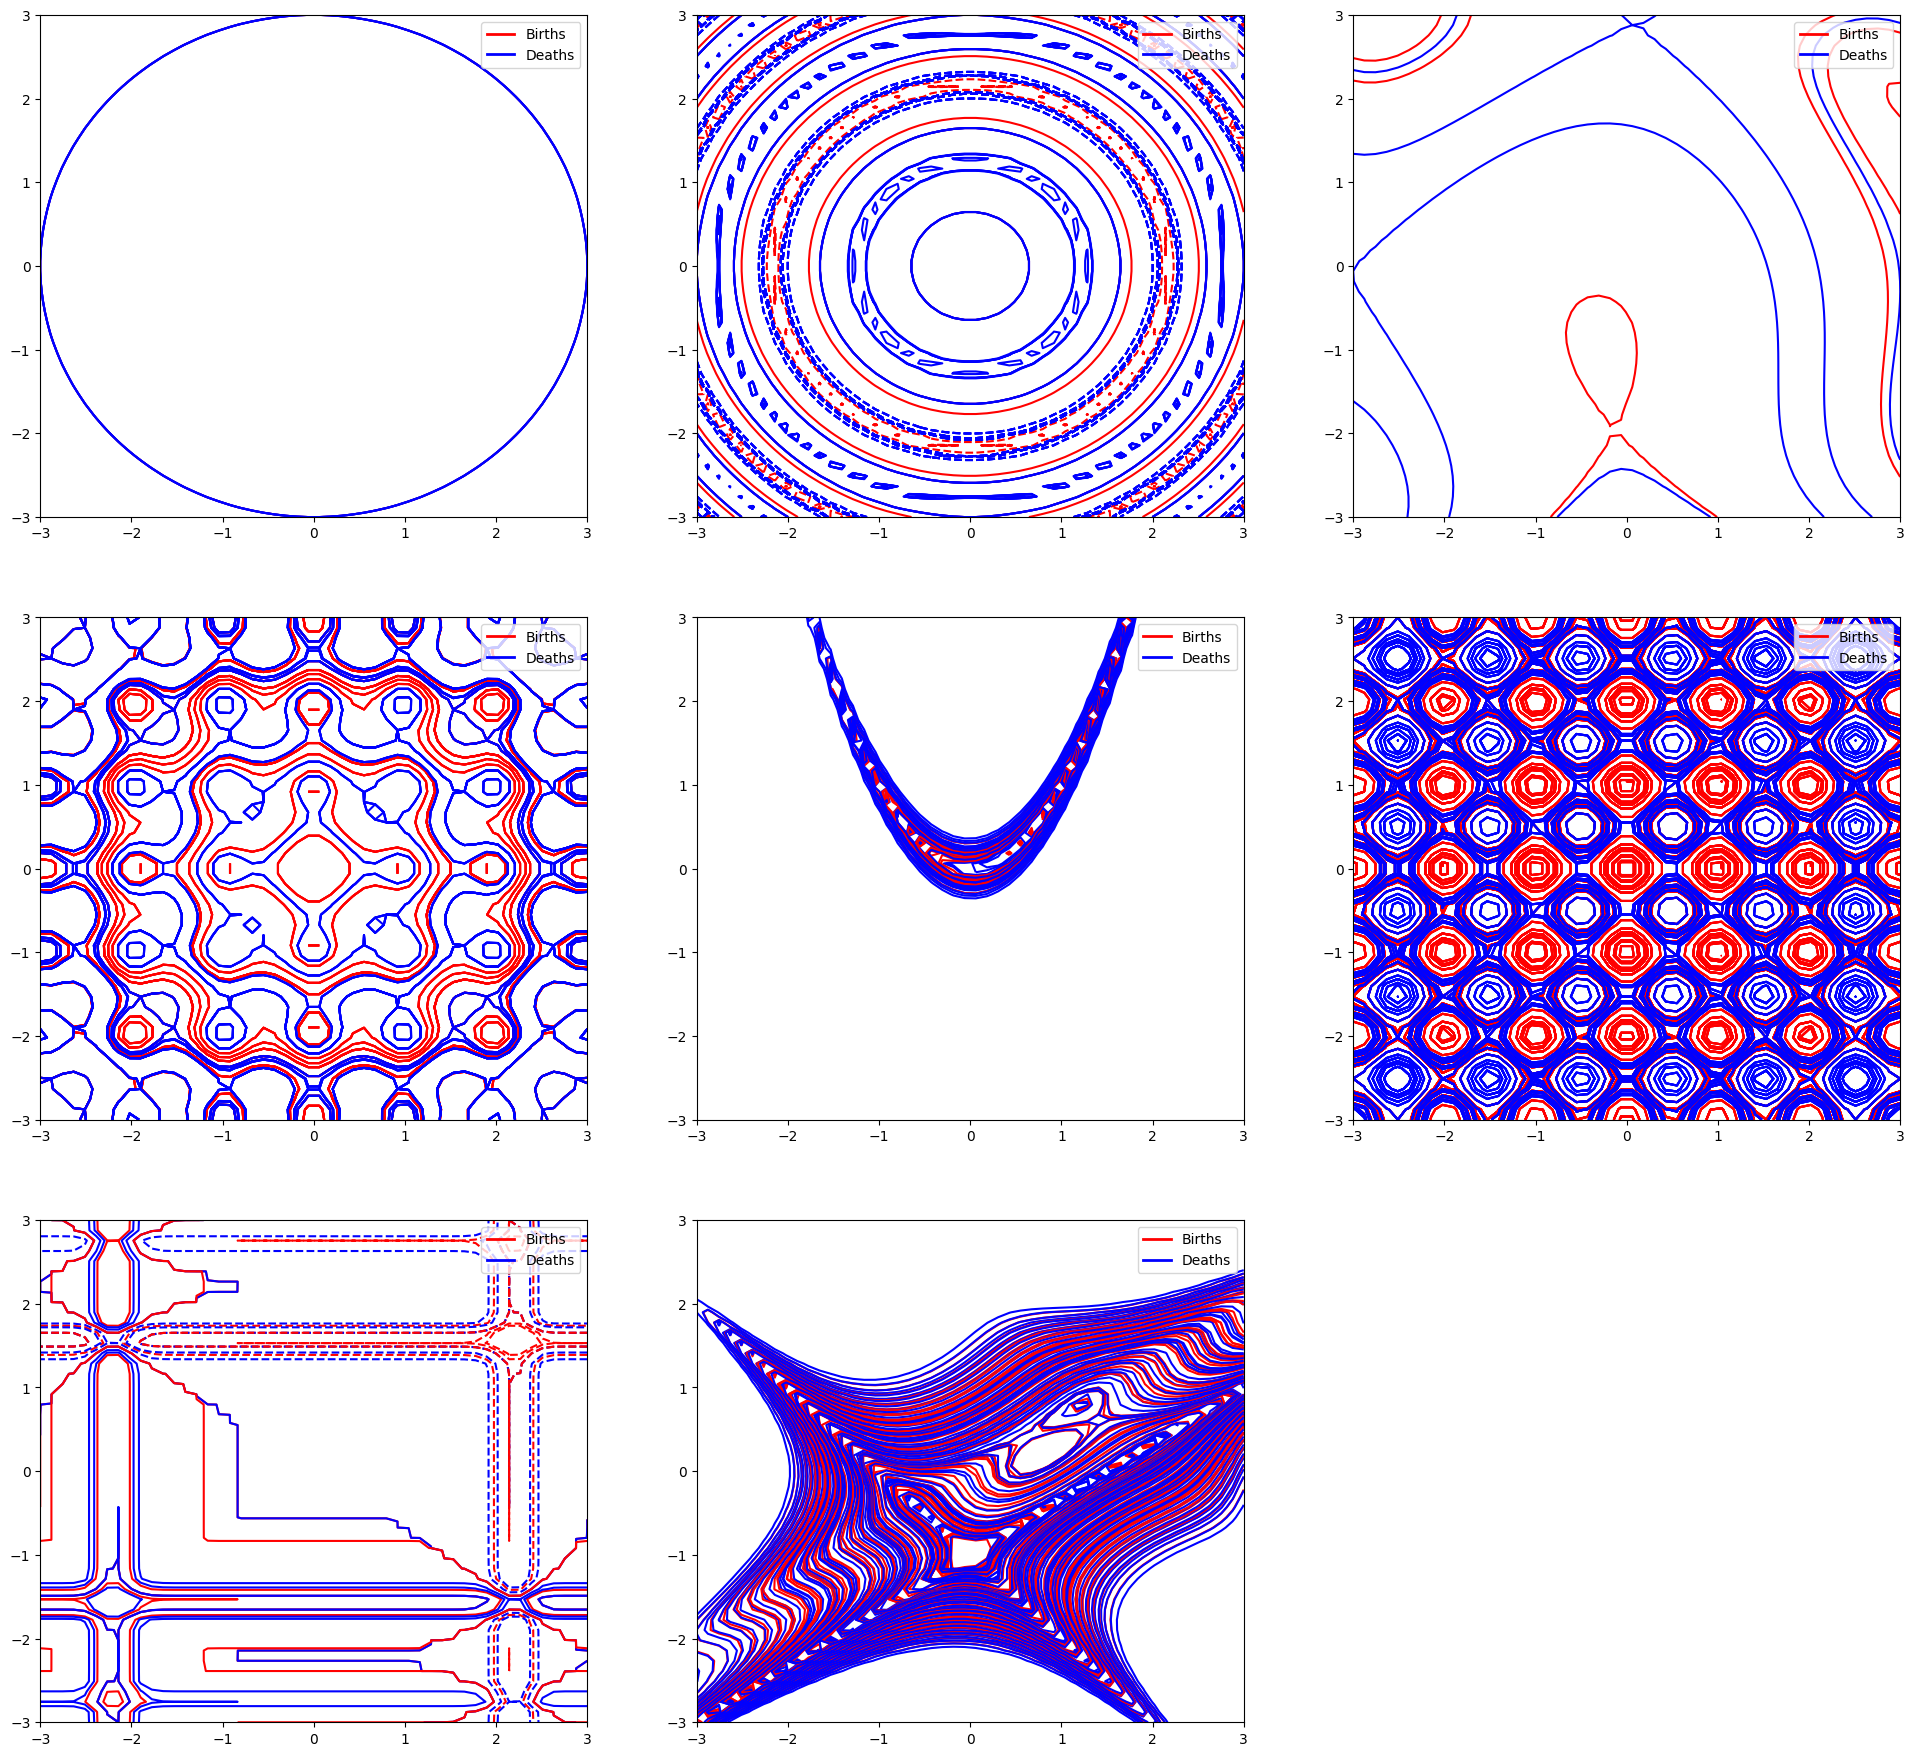

In [22]:
from matplotlib.lines import Line2D

fig = plt.figure(figsize=(24,30))
legend_elements = [Line2D([0], [0], color='red', lw=2, label='Births'),
                   Line2D([0], [0], color='blue', lw=2, label='Deaths')]
for i,(Z, persistence) in enumerate(zip(Zs, persistences)):
    significant_features = [p for p in persistence if p[1][1] - p[1][0] > 0.1]

    # Visualize the significant contours on the surface
    ax = fig.add_subplot(int(len(persistences)/2),3,i+1)
    for dimension, (birth, death) in significant_features:
        ax.contour(X, Y, Z, levels=[birth], colors='r')
        ax.contour(X, Y, Z, levels=[death], colors='b' )

    plt.legend(handles=legend_elements, loc='best')
plt.show()